In [3]:
import numpy as np
import pandas as pd

## Spike detection

In [6]:
#Formatting the date and price for Volza data
volza_pd = pd.read_csv("/Users/harshdeepsingh/ASU/Lab_V2/GSN/onr_price_prediction/volza/magnesium/magnesium.csv")
volza_pd = volza_pd[(volza_pd["Country of Origin"].notnull()) & (volza_pd["Country of Destination"].notnull())]
volza_pd = volza_pd.rename(columns={'Unnamed: 0': 'ID'})
volza_pd['Date'] = pd.to_datetime(volza_pd['Date'], format="mixed")

In [7]:
#Preprocessing the price data
prices_pd = pd.read_csv("/Users/harshdeepsingh/ASU/Lab_V2/GSN/onr_price_prediction/volza/magnesium/magnesium_price_2.csv")
prices_pd['Date'] = pd.to_datetime(prices_pd['Date'], format="mixed")
prices_pd['Price'] = prices_pd['Price'].str.replace(',', '').astype(float)
prices_pd = prices_pd[['Date','Price']]

In [8]:
#Aggregate volza data by day
date_wise_volza = volza_pd.groupby("Date")[['Value','Quantity','Gross Weight']].sum()

In [9]:
prices_pd = prices_pd.set_index('Date')
aggregated_df = date_wise_volza.join(prices_pd, how="left").fillna(method='ffill')

In [29]:
## Detecting spikes
window_size = 20  # Adjust the window size based on your data
moving_avg = aggregated_df['Price'].rolling(window=window_size).mean()
std_dev = aggregated_df['Price'].rolling(window=window_size).std()

# Set a threshold to identify spikes
threshold = 2  # You can adjust this value based on your data
spikes = (abs(aggregated_df['Price'] - moving_avg) > threshold * std_dev)
aggregated_df['spikes'] = (abs(aggregated_df['Price'] - moving_avg) > threshold * std_dev).astype(int)

In [30]:
#remove date 2020-01-01
aggregated_df = aggregated_df[aggregated_df.index != '2020-01-01']
aggregated_df

,Value,Quantity,Gross Weight,Price,spikes
Date,,,,,
2020-01-02,1.125000e+05,50040.00,89356.0,14150.0,0
2020-01-03,8.744076e+05,50222.26,25040.0,14100.0,0
2020-01-04,3.029376e+05,110028.00,0.0,14100.0,0
2020-01-05,4.420000e+04,20000.00,0.0,14100.0,0
2020-01-06,1.780024e+04,5001.00,2218.5,14100.0,0
...,...,...,...,...,...
2022-12-27,9.624998e+04,25180.00,250400.0,21700.0,0
2022-12-28,1.122651e+06,286996.89,80306.0,21650.0,0
2022-12-29,1.303649e+06,306928.00,0.0,21650.0,0


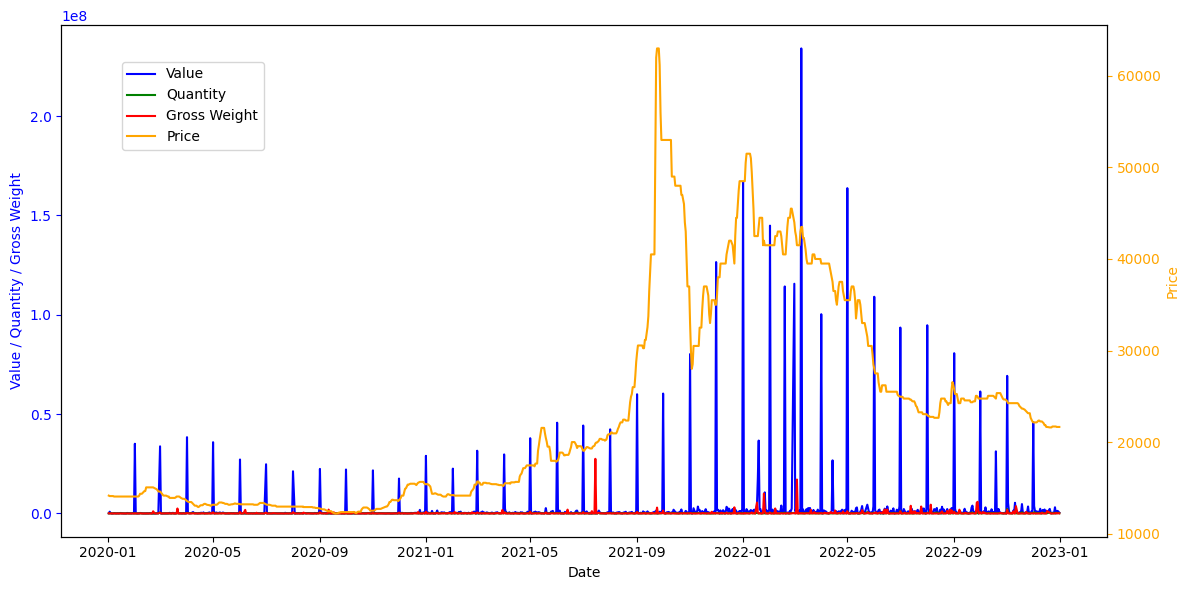

In [31]:
#Visualise Dataset

import matplotlib.pyplot as plt
# Plotting the graph
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting 'Value', 'Quantity', and 'Gross Weight' on the left y-axis
ax1.plot(aggregated_df.index, aggregated_df['Value'], label='Value', color='b')
ax1.plot(aggregated_df.index, aggregated_df['Quantity'], label='Quantity', color='g')
ax1.plot(aggregated_df.index, aggregated_df['Gross Weight'], label='Gross Weight', color='r')

ax1.set_xlabel('Date')
ax1.set_ylabel('Value / Quantity / Gross Weight', color='b')
ax1.tick_params('y', colors='b')

# Creating a second y-axis for 'Price'
ax2 = ax1.twinx()
ax2.plot(aggregated_df.index, aggregated_df['Price'], label='Price', color='orange')
ax2.set_ylabel('Price', color='orange')
ax2.tick_params('y', colors='orange')

# Display legend
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the graph
plt.show()

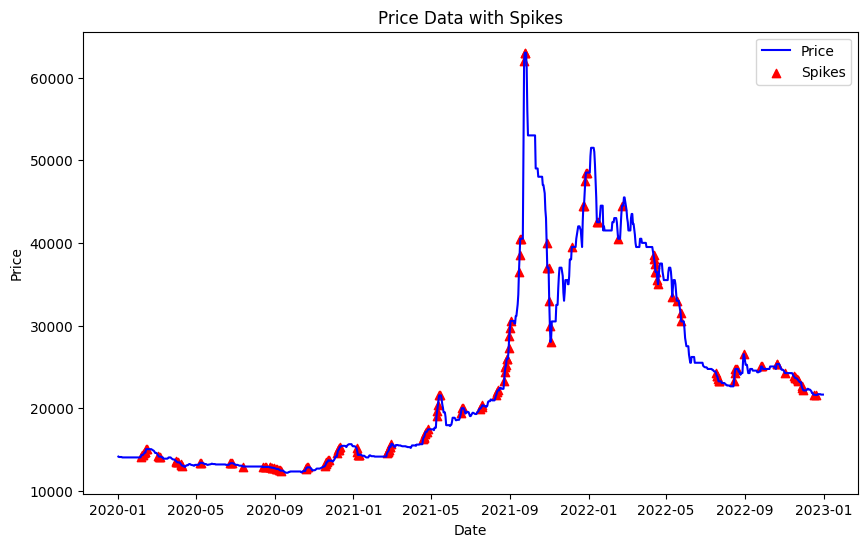

In [32]:
# Plotting the price data
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(aggregated_df.index, aggregated_df['Price'], label='Price', color='blue')

# Highlighting spikes
spike_indices = aggregated_df[aggregated_df['spikes'] == 1].index
spike_prices = aggregated_df.loc[spike_indices, 'Price']
plt.scatter(spike_indices, spike_prices, color='red', marker='^', label='Spikes')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Data with Spikes')
plt.legend()

# Display the plot
plt.show()

## Data Prep for Classification

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

time_series_df = aggregated_df.copy()
# Assuming 'time_series_df' is your DataFrame

# Drop rows with NaN in the 'spikes' column
time_series_df = time_series_df.dropna(subset=['spikes'])

# Extract features and target variable
X = time_series_df[['Value', 'Quantity', 'Gross Weight', 'Price']].values
y = time_series_df['spikes'].values

# Feature scaling using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create sequences for each sample with a window size of 5
window_size = 5
X_sequences, y_sequences = [], []

for i in range(len(X_scaled) - window_size + 1):
    X_sequences.append(X_scaled[i:i + window_size, :])
    y_sequences.append(y[i + window_size - 1])

X_sequences, y_sequences = np.array(X_sequences), np.array(y_sequences)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=50)

## LSTM

(776, 30, 4)
Epoch 1/100
25/25 [==============================] - 1s 10ms/step - loss: 0.5356 - auc_14: 0.5118
Epoch 2/100
25/25 [==============================] - 0s 12ms/step - loss: 0.4501 - auc_14: 0.5417
Epoch 3/100
25/25 [==============================] - 0s 10ms/step - loss: 0.4343 - auc_14: 0.5807
Epoch 4/100
25/25 [==============================] - 0s 10ms/step - loss: 0.4280 - auc_14: 0.6219
Epoch 5/100
25/25 [==============================] - 0s 10ms/step - loss: 0.4302 - auc_14: 0.6101
Epoch 6/100
25/25 [==============================] - 0s 10ms/step - loss: 0.4249 - auc_14: 0.6171
Epoch 7/100
25/25 [==============================] - 0s 10ms/step - loss: 0.4214 - auc_14: 0.6405
Epoch 8/100
25/25 [==============================] - 0s 11ms/step - loss: 0.4153 - auc_14: 0.6640
Epoch 9/100
25/25 [==============================] - 0s 11ms/step - loss: 0.4219 - auc_14: 0.6481
Epoch 10/100
25/25 [==============================] - 0s 10ms/step - loss: 0.4108 - auc_14: 0.6798
Epoch 

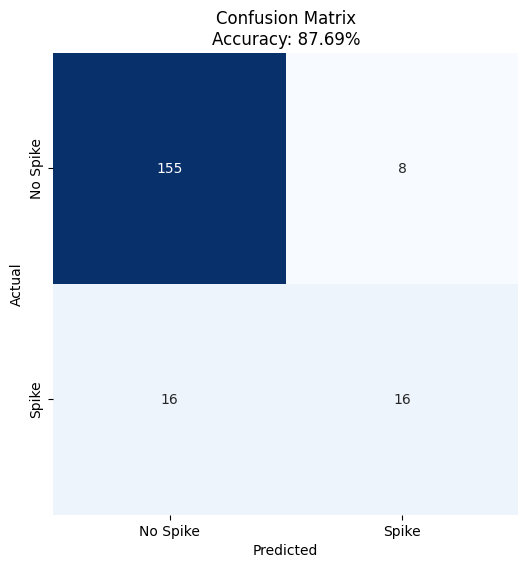

In [41]:
#LSTM Model

# Build the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

# Train the model
print(X_train.shape)
model.fit(X_train, y_train, epochs=100, batch_size=32)


y_pred = (model.predict(X_test) > 0.5).astype(int)


# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Display confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Spike', 'Spike'], yticklabels=['No Spike', 'Spike'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix\nAccuracy: {accuracy * 100:.2f}%')
plt.show()


## Random Forrest Classifier

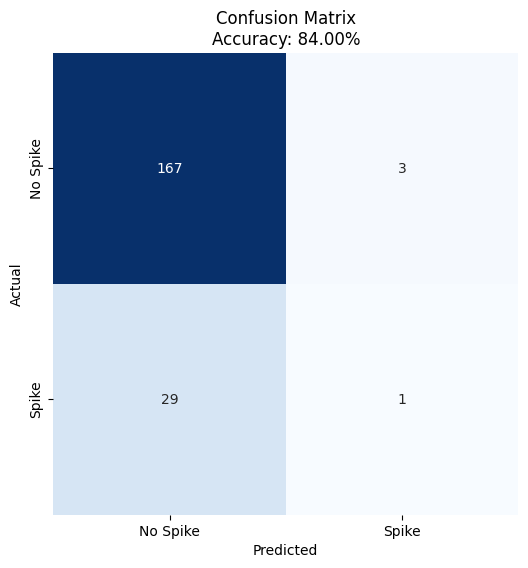

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Create a Random Forest Classifier
random_forest = RandomForestClassifier(n_estimators=10, random_state=213)

X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Train the classifier
random_forest.fit(X_train_reshaped, y_train)

# Make predictions on the test set
y_pred = random_forest.predict(X_test_reshaped)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Display confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Spike', 'Spike'], yticklabels=['No Spike', 'Spike'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix\nAccuracy: {accuracy * 100:.2f}%')
plt.show()


## OEC Trade Data

In [4]:
oed_data = spark.read.csv("/Users/harshdeepsingh/Downloads/trade_i_baci_a_12.tsv", header=True, sep="\t")

In [9]:
oed_data.printSchema()
magnesium_data = oed_data.filter(col("hs_code").like("8104%"))

root
 |-- year: string (nullable = true)
 |-- exporter_id: string (nullable = true)
 |-- exporter_name: string (nullable = true)
 |-- importer_id: string (nullable = true)
 |-- importer_name: string (nullable = true)
 |-- hs_code: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- hs_revision: string (nullable = true)
 |-- value: string (nullable = true)
 |-- quantity: string (nullable = true)
 |-- unit_abbrevation: string (nullable = true)
 |-- unit_name: string (nullable = true)



In [12]:
exported_mag_data = oed_data.groupBy("year","exporter_name").agg(F.sum("value").alias("export_value"),F.sum("quantity").alias("export_quantity"))

In [14]:
temp = exported_mag_data.withColumn("mag_price_calc", col("export_value")/col("export_quantity")).orderBy("year")

In [15]:
temp.filter("exporter_name == 'China'").show()

+----+-------------+-----------------+--------------------+------------------+
|year|exporter_name|     export_value|     export_quantity|    mag_price_calc|
+----+-------------+-----------------+--------------------+------------------+
|2012|        China|2.260997768731E12|1.3415590966399996E9|1685.3508536402007|
|2013|        China|2.361051744995E12|1.2268614859629998E9|1924.4648006386317|
|2014|        China|2.518285336019E12|1.3163803148299928E9|1913.0378262639322|
|2015|        China|2.424342836982E12| 1.376885918081996E9| 1760.743432076866|
|2016|        China| 2.33800166126E12|1.1329093881429954E9| 2063.714614539763|
|2017|        China|2.510171947467E12|1.2963361053690002E9|1936.3588941715723|
|2018|        China|2.732395800651E12| 7.466541738460068E8|3659.5198906830747|
|2019|        China|2.676977757884E12| 1.358131188107999E9|1971.0745039389565|
|2020|        China|2.682346446118E12| 7.566523887799981E8| 3545.018142932092|
|2021|        China| 3.35571766303E12| 8.00565200676